In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits, make_moons
import matplotlib.pyplot as plt
import torch

In [ ]:
from typing import List, Optional

## Flow Matcing Example Using Checker Board

In [ ]:
def make_checker_board(num_sample:int) -> torch.tensor:
    """
    Returns a Checker Board Pattern of dim (num_sample*16, 2)
    """
    dim = 2
    noise1 = torch.FloatTensor(num_sample, dim).uniform_(0.0, 1.0)
    noise2 = torch.FloatTensor(num_sample, dim).uniform_(1.0, 2.0)
    noise3 = torch.FloatTensor(num_sample, dim).uniform_(2.0, 3.0) - torch.tensor([0.0, 2.0])
    noise4 = torch.FloatTensor(num_sample, dim).uniform_(3.0, 4.0) - torch.tensor([0.0, 2.0])

    first_quad = torch.cat((noise1, noise2), dim=0)
    second_quad = first_quad - torch.tensor([2.0, 0.0])
    third_quad = first_quad * torch.tensor([-1.0, -1.0])
    fourth_quad = first_quad - torch.tensor([0.0, 2.0])

    noise = torch.cat((first_quad, second_quad, third_quad, fourth_quad), dim=0)
    return noise

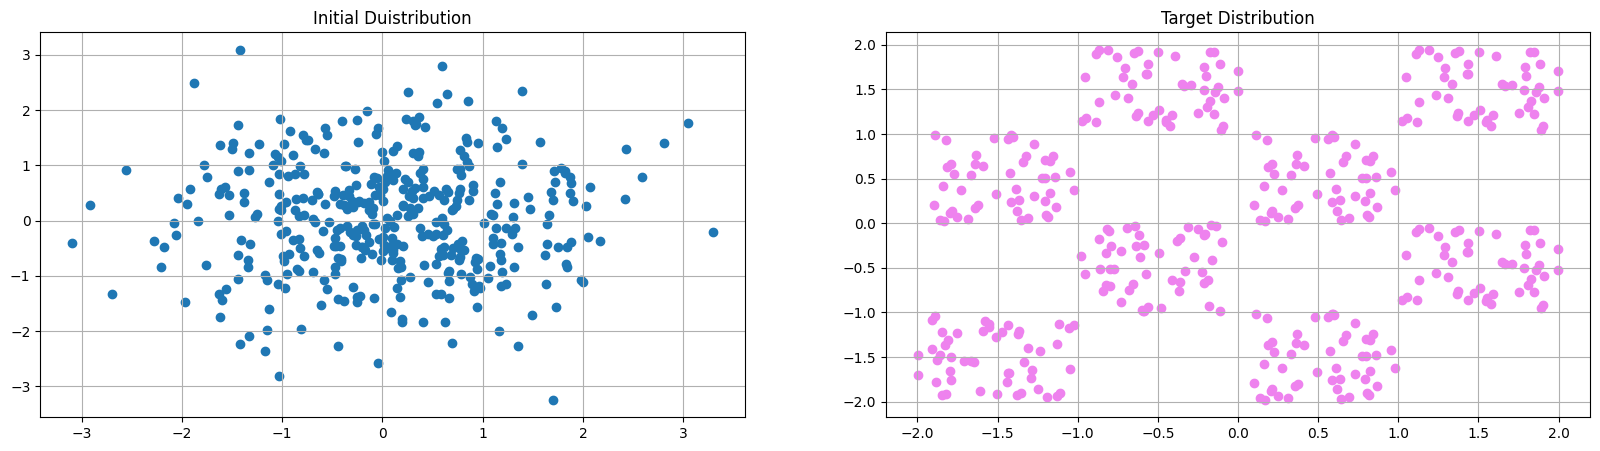

In [ ]:
data_dist = make_checker_board(50)
init_dist = torch.randn_like(data_dist)

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(init_dist[:, 0], init_dist[:, 1])
plt.title("Initial Duistribution")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(data_dist[:, 0], data_dist[:, 1], c='violet')
plt.title("Target Distribution")

plt.grid(True)
plt.show()

In [ ]:
init_dist.shape, data_dist.shape

(torch.Size([400, 2]), torch.Size([400, 2]))

## Simple Neural Network Model

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class FlowMatchingModel(nn.Module):
    def __init__(self, input_dim:int = 2):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim+1, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 512), nn.ReLU(),
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 2)
        )
    
        
    def forward(self, x:torch.tensor, t:torch.tensor):
        x = torch.cat((x, t), dim=-1)
        return self.layer(x)

    def step(self, x_t:torch.tensor, t:torch.tensor, dt:torch.tensor):
        u_t = self(x_t, t)
        return x_t + u_t * dt

    @torch.no_grad
    def sample(self, x_0:torch.tensor, num_step:int):
        x_t = x_0
        time_steps = torch.linspace(0.0, 1.0, num_step)
        for i in range(len(time_steps)-1):
            dt = time_steps[i+1] - time_steps[i]
            t = torch.full((x_t.shape[0], 1), time_steps[i])
            x_t = self.step(x_t, t, dt)
        return x_t

In [ ]:
# model = FlowMatchingModel()

# num_sample = 100
# dummy_input = torch.rand(num_sample, 2)
# time = torch.FloatTensor(num_sample, 1).uniform_(0.0, 1.0)
# output = model(dummy_input, time)
# output.shape

torch.Size([100, 2])

## Training Flow Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FlowMatchingModel().to(device=device)
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

cpu


In [ ]:
epochs = 1000
for epoch in range(epochs):
    target = make_checker_board(50).to(device)
    # target = torch.tensor(make_moons(1000, noise=0.05, shuffle=True)[0], dtype=torch.float32).to(device)
    noise = torch.randn_like(target)
    t = torch.rand(target.shape[0], 1).to(device)
    # t = torch.FloatTensor(target.shape[0], 1).uniform_(0.0, 1.0).to(device)
    
    xt = ( 1- t) * noise + t * target
    output = model(xt, t)
    
    loss = Loss(output, target-noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    print(f"epoch : {epoch}/{epochs}: Loss : {loss.item()}")
        

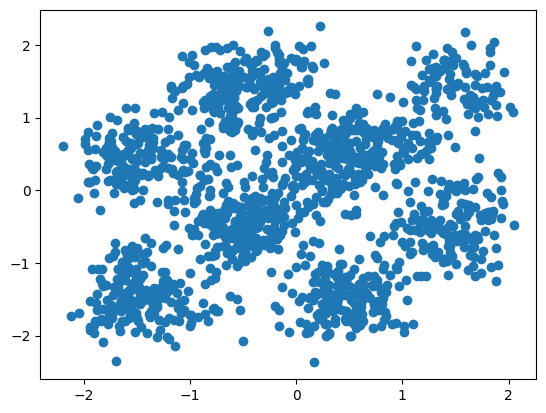

In [ ]:
x_0 = torch.randn(1500, 2)
x_1 = model.sample(x_0, 15)
plt.scatter(x_1[:, 0].detach().numpy(), x_1[:, 1].detach().numpy())

In [ ]:
# t = torch.FloatTensor(target.shape[0], 1).uniform_(0.0, 1.0)
# t
torch.FloatTensor(2,2).uniform_(0.0, 1.0)

tensor([[0.1563, 0.1383],
        [0.5559, 0.1241]])

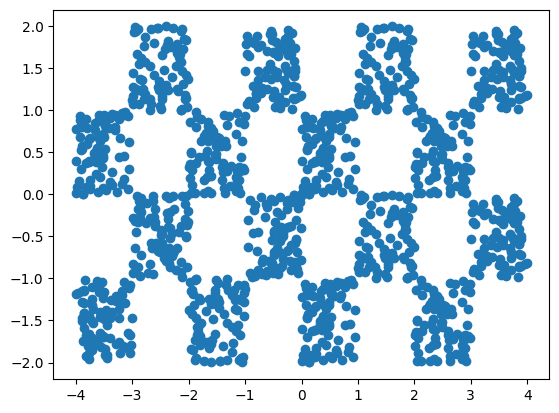

In [ ]:
plt.scatter(target[:,0], target[:,1])

In [ ]:
data = load_digits(as_frame=True)
data['data']['target'] = data['target']
df = data['data'].copy()

In [ ]:
sample = df.iloc[0, :-1].values
sample = torch.tensor(sample)
sample = sample.reshape(8, 8)

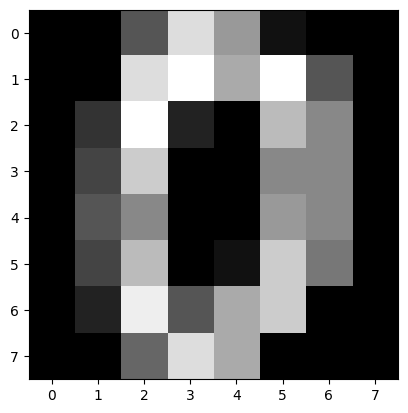

In [ ]:
plt.imshow(sample, cmap='gray')

In [ ]:
df

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,pixel_1_2,pixel_1_3,pixel_1_4,pixel_1_5,pixel_1_6,pixel_1_7,pixel_2_0,pixel_2_1,pixel_2_2,pixel_2_3,pixel_2_4,pixel_2_5,pixel_2_6,pixel_2_7,pixel_3_0,pixel_3_1,pixel_3_2,pixel_3_3,pixel_3_4,pixel_3_5,pixel_3_6,pixel_3_7,pixel_4_0,pixel_4_1,pixel_4_2,pixel_4_3,pixel_4_4,pixel_4_5,pixel_4_6,pixel_4_7,pixel_5_0,pixel_5_1,pixel_5_2,pixel_5_3,pixel_5_4,pixel_5_5,pixel_5_6,pixel_5_7,pixel_6_0,pixel_6_1,pixel_6_2,pixel_6_3,pixel_6_4,pixel_6_5,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,16.0,14.0,12.0,16.0,3.0,0.0,0.0,4.0,16.0,6.0,3.0,16.0,4.0,0.0,0.0,0.0,12.0,16.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,4.0,4.0,16.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,0.0,5.0,7.0,7.0,16.0,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,16.0,15.0,12.0,16.0,1.0,0.0,0.0,3.0,16.0,7.0,0.0,13.0,6.0,0.0,0.0,4.0,16.0,0.0,0.0,10.0,8.0,0.0,0.0,8.0,16.0,0.0,0.0,14.0,6.0,0.0,0.0,5.0,16.0,7.0,9.0,16.0,5.0,0.0,0.0,1.0,15.0,16.0,16.0,16.0,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,13.0,16.0,8.0,2.0,1.0,0.0,0.0,0.0,16.0,15.0,10.0,16.0,5.0,0.0,0.0,0.0,8.0,16.0,16.0,7.0,0.0,0.0,0.0,0.0,9.0,16.0,16.0,4.0,0.0,0.0,0.0,0.0,16.0,14.0,16.0,15.0,0.0,0.0,0.0,0.0,15.0,15.0,15.0,16.0,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,14.0,16.0,16.0,15.0,1.0,0.0,0.0,4.0,16.0,7.0,3.0,16.0,7.0,0.0,0.0,5.0,16.0,10.0,7.0,16.0,4.0,0.0,0.0,0.0,5.0,14.0,14.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,2.0,0.0,0.0,0.0,4.0,7.0,7.0,16.0,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9
